In [1]:
import tuxml
import pandas as pd 

df = tuxml.load_dataset()

In [2]:
df.sort_values("vmlinux")[:10]

,X86_LOCAL_APIC,OPENVSWITCH,TEXTSEARCH_FSM,LOCKDEP_SUPPORT,GENERIC_CLOCKEVENTS_MIN_ADJUST,NETFILTER_XT_MATCH_TCPMSS,MPLS,NFC_HCI,STACKTRACE_SUPPORT,GENERIC_CMOS_UPDATE,...,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4,cid,nbyes,nbno,nbmodule,nbyesmodule
109097,1,0,0,1,1,0,0,0,1,1,...,2863640,644621,814544.0,2900824,669288,124978,241,12237,0,241
58621,1,0,0,1,1,0,0,0,1,1,...,2777624,558712,724432.0,2810712,578375,74458,240,12238,0,240
107213,1,0,0,1,1,0,0,0,1,1,...,3953176,1734208,1986512.0,4072280,1841339,123091,741,11068,669,1410
99232,1,0,0,1,1,0,0,0,1,1,...,4248440,2027905,2290640.0,4375728,2144007,115110,636,11131,711,1347
99777,1,0,0,1,1,0,0,0,1,1,...,4096536,1877790,2139088.0,4223832,1994471,115655,721,11351,406,1127
91160,1,0,0,1,1,0,0,0,1,1,...,4297240,2077003,2347472.0,4432728,2203924,107038,847,10831,800,1647
109537,1,0,0,1,1,0,0,0,1,1,...,4232056,2011955,2282448.0,4367536,2133755,125418,724,11226,528,1252
80771,1,0,0,1,1,0,0,0,1,1,...,4338200,2120182,2397136.0,4481880,2251054,96648,857,11163,458,1315
66399,1,0,0,1,1,0,0,0,1,1,...,4621176,2401304,2691024.0,4777136,2542313,82269,816,10731,931,1747
96643,1,0,0,1,1,0,0,0,1,1,...,4928376,2707431,3019728.0,5104816,2870154,112521,835,10926,717,1552


In [3]:
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

In [4]:
additional_features = ["nbyes", "nbno", "nbmodule", "nbyesmodule"]

In [5]:
#Creating dummy variables in pandas
col = list(df.drop(columns=["cid"]).drop(columns=size_methods).drop(columns=additional_features).columns.values)
df = pd.get_dummies(df, columns=col)
df.head()

,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,...,CHARGER_BQ24190_1,CHARGER_BQ24190_2,SND_SOC_NAU8825_0,SND_SOC_NAU8825_1,SND_SOC_NAU8825_2,BH1750_0,BH1750_1,BH1750_2,NETWORK_FILESYSTEMS_0,NETWORK_FILESYSTEMS_1
14758,50222120,7603152.0,9689768,7403313,11789264.0,13875328,7471985,5940176.0,8026272,5748333,...,1,0,1,0,0,1,0,0,1,0
14759,16660024,4109776.0,6194296,3964503,8160720.0,10244688,3898077,3388880.0,5472880,3251714,...,0,1,0,0,1,0,0,1,1,0
14760,43080856,11191760.0,13276280,11046541,15177168.0,17261136,10912607,8836560.0,10920560,8701273,...,0,0,1,0,0,1,0,0,1,0
14761,27261672,8053712.0,10139088,7907068,11850704.0,13935528,7584629,6640592.0,8725456,6505081,...,1,0,1,0,0,0,1,0,1,0
14762,58769440,16135120.0,18220496,15986281,20018128.0,22102952,15752717,12706768.0,14791632,12569419,...,1,0,1,0,0,0,1,0,0,1


In [35]:
#learning a model by using linear regression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import ElasticNet

def run_regressorML(reg, test_size, size_target="vmlinux"):
    assert(size_target in size_methods)
    x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods).drop(columns=additional_features), df[size_target], test_size=test_size, random_state=42)  
    x_train, y_train = np.array(x_train.values), np.array(y_train.values)
    reg.fit(x_train, y_train)
    
    #r_sq = reg.score(x_train, y_train)
    #print('coefficient of determination:', r_sq)
    #print('intercept:', reg.intercept_)
    #print('slope:', reg.coef_)

    #validation
    y_pred = reg.predict(x_test)
    #y_pred = reg.intercept_ + np.sum(reg.coef_ * x_test.values, axis=1)
    dfErrors = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, "error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
    return dfErrors["% error"].describe()

In [36]:
def ft_importances(reg):
    col = df.drop(columns=["cid"]).drop(columns=size_methods).drop(columns=additional_features).columns
    
    importanceSeries = pd.Series(reg.coef_, index=col.values)
    return importanceSeries[importanceSeries != 0].abs().sort_values(ascending = False)

In [8]:
col_names =  ['algorithm_name', 'feature_selection', 'hyperparameters', 'size_target', 'additional_features', 'test_size', 'coefficients', 'accuracy']
df_result  = pd.DataFrame(columns = col_names)

In [33]:
size_target="vmlinux"
#["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]
feature_selection = False
additional_ft= False

In [38]:
#learning a model by using multiple linear regression
algorithm_name="Multiple Linear Regression"
test_size=0.8

#for test_size in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]: 
reg_model = LinearRegression()
res_model = run_regressorML(reg_model, test_size, size_target)
order_lr = ft_importances(reg_model)
order_lr.to_csv("feature_importanceLR_.csv", header=True)
df_result.loc[len(df_result)] = [algorithm_name, feature_selection, None, size_target, additional_ft, test_size, order_lr, res_model]
df_result.to_csv('results_lr', sep='\t')
    
df_result

,algorithm_name,feature_selection,hyperparameters,size_target,additional_features,test_size,coefficients,accuracy
0,Multiple Linear Regression,False,None,vmlinux,True,0.9,DEBUG_INFO_1 7.177512e+07...,count 83224.000000 mean 213.891041 st...
1,Multiple Linear Regression,False,None,vmlinux,True,0.8,nbyesmodule 1.336812e+...,count 7.397700e+04 mean 3.921063e+05 st...
2,Lasso,False,"alpha=0.03, copy_X=True, fit_intercept=True, m...",vmlinux,True,0.9,XEN_BLKDEV_BACKEND_2 2.005286e+...,count 83224.000000 mean 226.788780 st...
3,Lasso,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.8,DEBUG_INFO_0 2.208956e+08 ...,count 73977.000000 mean 231.514744 st...
4,Ridge Regression,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.9,DEBUG_INFO_1 7.146505e+07 DEBUG...,count 83224.000000 mean 211.773312 st...
5,Ridge Regression,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.8,DEBUG_INFO_1 1.098532e+08 ...,count 73977.000000 mean 217.039148 st...
6,ElasticNet,False,"alpha=0.5, copy_X=True, fit_intercept=True, l1...",vmlinux,True,0.9,DEBUG_INFO_1 1.613479e...,count 83224.000000 mean 61.652284 st...
7,ElasticNet,False,"alpha=0.2, copy_X=True, fit_intercept=True, l1...",vmlinux,True,0.8,DEBUG_INFO_0 2.83312...,count 73977.000000 mean 59.839469 st...
8,Multiple Linear Regression,False,None,vmlinux,False,0.9,DEBUG_INFO_1 7.1824...,count 83224.000000 mean 213.897489 st...
9,Multiple Linear Regression,False,None,vmlinux,False,0.8,GENERIC_CPU_AUTOPROBE_1 2.093680e+...,count 7.397700e+04 mean 7.962751e+09 st...


In [30]:
#tune hyperparameters
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn import linear_model

#params = 10**np.linspace(10,-2,100)*0.5
params = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5]}

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods), df[size_target], test_size=0.8, random_state=42)  
x_train, y_train = np.array(x_train.values), np.array(y_train.values)
reg_model = GridSearchCV(ElasticNet(), param_grid=params).fit(x_train, y_train).best_estimator_ #best_params_
reg_model

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python

ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
#learning a model by using Lasso
algorithm_name="Lasso"
test_size=0.8

#for test_size in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]: 
reg_model = linear_model.Lasso(alpha=0.5)
hyperparameters = "alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False"
res_model = run_regressorML(reg_model, test_size, size_target)
order_lasso = ft_importances(reg_model)
order_lasso.to_csv("feature_importanceLasso.csv", header=True)
df_result.loc[len(df_result)] = [algorithm_name, feature_selection, hyperparameters, size_target, additional_ft, test_size, order_lasso, res_model]
df_result.to_csv('results_lr', sep='\t')
    
df_result

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,algorithm_name,feature_selection,hyperparameters,size_target,additional_features,test_size,coefficients,accuracy
0,Multiple Linear Regression,False,None,vmlinux,True,0.9,DEBUG_INFO_1 7.177512e+07...,count 83224.000000 mean 213.891041 st...
1,Multiple Linear Regression,False,None,vmlinux,True,0.8,nbyesmodule 1.336812e+...,count 7.397700e+04 mean 3.921063e+05 st...
2,Lasso,False,"alpha=0.03, copy_X=True, fit_intercept=True, m...",vmlinux,True,0.9,XEN_BLKDEV_BACKEND_2 2.005286e+...,count 83224.000000 mean 226.788780 st...
3,Lasso,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.8,DEBUG_INFO_0 2.208956e+08 ...,count 73977.000000 mean 231.514744 st...


In [27]:
#learning a model by using Ridge regression
algorithm_name="Ridge Regression"
test_size=0.8

#for test_size in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]: 
reg_model = linear_model.Ridge(alpha=0.5)
hyperparameters = "alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001"
res_model = run_regressorML(reg_model, test_size, size_target="vmlinux")
order_ridge = ft_importances(reg_model)
order_ridge.to_csv("feature_importanceRidge.csv", header=True)
df_result.loc[len(df_result)] = [algorithm_name, feature_selection, hyperparameters, size_target, additional_ft, test_size, order_ridge, res_model]
df_result.to_csv('results_lr', sep='\t')

df_result

,algorithm_name,feature_selection,hyperparameters,size_target,additional_features,test_size,coefficients,accuracy
0,Multiple Linear Regression,False,None,vmlinux,True,0.9,DEBUG_INFO_1 7.177512e+07...,count 83224.000000 mean 213.891041 st...
1,Multiple Linear Regression,False,None,vmlinux,True,0.8,nbyesmodule 1.336812e+...,count 7.397700e+04 mean 3.921063e+05 st...
2,Lasso,False,"alpha=0.03, copy_X=True, fit_intercept=True, m...",vmlinux,True,0.9,XEN_BLKDEV_BACKEND_2 2.005286e+...,count 83224.000000 mean 226.788780 st...
3,Lasso,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.8,DEBUG_INFO_0 2.208956e+08 ...,count 73977.000000 mean 231.514744 st...
4,Ridge Regression,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.9,DEBUG_INFO_1 7.146505e+07 DEBUG...,count 83224.000000 mean 211.773312 st...
5,Ridge Regression,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.8,DEBUG_INFO_1 1.098532e+08 ...,count 73977.000000 mean 217.039148 st...


In [31]:
#learning a model by using ElasticNet
algorithm_name="ElasticNet"
test_size=0.8

#for test_size in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
reg_model = ElasticNet(alpha=0.2, l1_ratio=0.5)
hyperparameters = "alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.5, max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False"
res_model = run_regressorML(reg_model, test_size, size_target)
order_en = ft_importances(reg_model)
order_en.to_csv("feature_importanceEN.csv", header=True)
df_result.loc[len(df_result)] = [algorithm_name, feature_selection, hyperparameters, size_target, additional_ft, test_size, order_en, res_model]
df_result.to_csv('results_lr', sep='\t')

df_result

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,algorithm_name,feature_selection,hyperparameters,size_target,additional_features,test_size,coefficients,accuracy
0,Multiple Linear Regression,False,None,vmlinux,True,0.9,DEBUG_INFO_1 7.177512e+07...,count 83224.000000 mean 213.891041 st...
1,Multiple Linear Regression,False,None,vmlinux,True,0.8,nbyesmodule 1.336812e+...,count 7.397700e+04 mean 3.921063e+05 st...
2,Lasso,False,"alpha=0.03, copy_X=True, fit_intercept=True, m...",vmlinux,True,0.9,XEN_BLKDEV_BACKEND_2 2.005286e+...,count 83224.000000 mean 226.788780 st...
3,Lasso,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.8,DEBUG_INFO_0 2.208956e+08 ...,count 73977.000000 mean 231.514744 st...
4,Ridge Regression,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.9,DEBUG_INFO_1 7.146505e+07 DEBUG...,count 83224.000000 mean 211.773312 st...
5,Ridge Regression,False,"alpha=0.5, copy_X=True, fit_intercept=True, ma...",vmlinux,True,0.8,DEBUG_INFO_1 1.098532e+08 ...,count 73977.000000 mean 217.039148 st...
6,ElasticNet,False,"alpha=0.5, copy_X=True, fit_intercept=True, l1...",vmlinux,True,0.9,DEBUG_INFO_1 1.613479e...,count 83224.000000 mean 61.652284 st...
7,ElasticNet,False,"alpha=0.2, copy_X=True, fit_intercept=True, l1...",vmlinux,True,0.8,DEBUG_INFO_0 2.83312...,count 73977.000000 mean 59.839469 st...


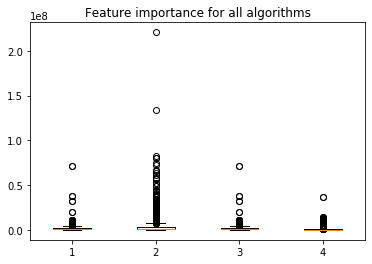

In [44]:
# Boxplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = [order_lr, order_lasso, order_ridge, order_en]
fig1, ax1 = plt.subplots()
ax1.set_title('Coeficient of feature importance for all algorithms')
ax1.boxplot(data)
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

params = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5]}

pipe = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Lasso())])

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods), df[size_target], test_size=0.9, random_state=42)  
x_train, y_train = np.array(x_train.values), np.array(y_train.values)
reg_model = GridSearchCV(pipe, param_grid=params).fit(x_train, y_train).best_estimator_ #best_params_
reg_model


In [116]:
df_importance = pd.read_csv("feature_importanceRF.csv")
df_importance.head()

,Unnamed: 0,0
0,DEBUG_INFO,0.342894
2,DEBUG_INFO_REDUCED,0.114845
3,DEBUG_INFO_SPLIT,0.093297
4,X86_NEED_RELOCS,0.062620
5,RANDOMIZE_BASE,0.060661


In [ ]:
size_target="vmlinux"
feature_selection = "Top-100 Random Forest"
additional_ft= True

In [118]:
#learning a model by using polynomial regression degree=2
from sklearn.preprocessing import PolynomialFeatures

algorithm_name="Polynomial Regression"
test_size=0.9

reg = LinearRegression()
#x_train, x_test, y_train, y_test = train_test_split(df[order_en[:30].index], df["vmlinux"], test_size=0.9, random_state=42)  
x_train, x_test, y_train, y_test = train_test_split(df[df_importance[:100]["Unnamed: 0"].values], df["vmlinux"], test_size, random_state=42)  
x_train, y_train = np.array(x_train.values), np.array(y_train.values)
reg.fit(x_train, y_train)

#for 2 options we have: 𝑓(𝑥₁, 𝑥₂) = 𝑏₀ + 𝑏₁𝑥₁ + 𝑏₂𝑥₂ + 𝑏₃𝑥₁² + 𝑏₄𝑥₁𝑥₂ + 𝑏₅𝑥₂²
x_train_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_train)
hyperparameters = "degree=2, include_bias=False"

model = LinearRegression().fit(x_train_, y_train)

#validation
x_test_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_test)
y_pred = model.predict(x_test_)

dfErrors = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, "error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
dfErrors["% error"].describe()

count    83224.000000
mean        30.540919
std         29.411421
min          0.000167
25%         10.772569
50%         22.962595
75%         40.733938
max        459.692992
Name: % error, dtype: float64